# Notes about simulation:

**Running info**
- 2250 simulations
- week queue

**EA params**
- 160 generations
- 250 individuals
- 0.1 mutation rate
- 0.5 crossover rate

**Parameter search space**
- beta_0,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
- minimums = [ -4,   -2, -2, -2, -2,   -2, -2, -2, -2,   -2, -2,     -2, -2, -2, -2,    -2, -2, -2, -2]
- maximums = [4.5,    4,  4,  4,  4,    4,  4,  4,  4,    4,  4,     4,   4,  4,  4,     4,  4,  4,  4]

**Mean of Mean Square Error of the top 2.5% of Individuals** 
- 1404.57196018


$$MAP3K_I = MAP3K_t-MAP3K$$
$$MAP2K_I = MAP2K_t-MAP2K$$
$$MAPK_I = MAPK_t-MAPK$$


$$\dfrac{dMAP3K}{dt} = \dfrac{ s}{1+\dfrac{MAPK}{\beta}} \cdot \dfrac{k1\cdot MAP3K_I}{K_1 + MAP3K_I} - \dfrac{k2\cdot MAP3K}{K_2+MAP3K}$$

$$\dfrac{dMAP2K}{dt} = \dfrac{k3\cdot MAP3K\cdot MAP2K_I}{K_3 + MAP2K_I} - \dfrac{k4\cdot MAP2K}{K_4+MAP2K}$$

$$\dfrac{dMAPK}{dt} = \dfrac{k5\cdot MAP2K\cdot MAPK_I}{K_5 + MAPK_I} - \dfrac{k6\cdot MAPK}{K_6+MAPK}$$


# Import packages and set settings

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import os
import itertools

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

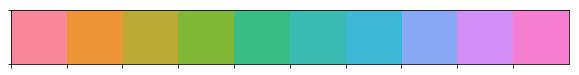

In [4]:
sns.palplot(sns.husl_palette(10, l=.7))
palette_husl = sns.husl_palette(10, l=.7)
# palette_husl.as_hex()
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()

# Supporting Functions

In [17]:
def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

def get_closest_tps(scorefxn_time,time):
    idx_closest_time_points = []
    for each_time in scorefxn_time:
        closest_idx = min(range(len(time)),
                          key = lambda i: abs(time[i] - each_time))
        idx_closest_time_points.append(closest_idx)
    return idx_closest_time_points

# def convert_individual(ea_individual, conversion_matrix, number_of_params):
    # copy and get len of individual
    arr_params_conv = np.zeros(number_of_params)#np.copy(arr_parameters)
    len_ind = len(ea_individual)

    # Interp:
    for idx in np.nonzero(conversion_matrix[0])[0]:
        ea_val = ea_individual[idx]
        r_min = conversion_matrix[1][idx]
        r_max = conversion_matrix[2][idx]
        arr_params_conv[idx] = np.interp(ea_val, (0,1), (r_min, r_max))

    # Exponentiate:
    for idx in np.nonzero(conversion_matrix[3])[0]:
        ea_val = arr_params_conv[idx]
        base_val = conversion_matrix[4][idx]
        arr_params_conv[idx] = np.power(base_val, ea_val)

    # arr_params_conv[-4:] = np.round(arr_params_conv[-4:],0)

    return arr_params_conv

def scorefxn2(scorefxn_data, inits, params_constants,
              learned_params, time, scorefxn_time):
    sse_total = 0
#     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

    for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
        params_constants_sig = params_constants[:-1]+[sig]

        for fxn, exp_data in zip([simulate_wt_experiment,simulate_t100a_experiment],[MAPK_wt_data, MAPK_t100a_data]):
            data = fxn(inits, params_constants_sig, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            _scorefxn_data_active = active[[scorefxn_time]]
            error_active = ((exp_data - _scorefxn_data_active)**2).sum()
            sse_total += error_active
    return sse_total/(len(idx_closest_time_points)*len(params_constants[-1])-len(learned_params))

def scorefxn1(scorefxn_data, inits, params_constants,
              learned_params, time, scorefxn_time):
    sse_total = 0
#     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

    for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
        params_constants_sig = params_constants[:-1]+[sig]

        for fxn, exp_data in zip([simulate_wt_experiment,simulate_t100a_experiment],[MAPK_wt_data, MAPK_t100a_data]):
            data = fxn(inits, params_constants_sig, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            _scorefxn_data_active = active[[scorefxn_time]]
            error_active = ((exp_data - _scorefxn_data_active)**2).mean()
            sse_total += error_active
    return sse_total

def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44
    return molecules/(Na*cell_volume*10**-15)*1000000

def gather_simulated_data(folder, gen, runs, top_plotting):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1

    top = round((runs-empty_data)*top_plotting)
    plt_top = round((runs-empty_data)*top_plotting)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
#     last_mses = last_mses
    new_params = np.asarray(new_params)
    new_params = new_params.T

    idx_top = last_mses.argsort()[:top]

    top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
    # top_params = []
    # for idx in idx_top:
    #     top_params.append(params_from_file[idx][100])

    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses

def plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('% phosopho-MAPK', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
    for sig, wt_data in zip([0, 50000, 150000, 250000, 350000, 450000, 550000], mapk_wt_data):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette.get(sig), label = str(int(sig/1000))+'mM KCl')
#     ax1.legend()
        
    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('% phosopho-MAPK', fontsize=16)
    
    for sig, t100a_data in zip([0, 50000, 150000, 250000, 350000, 450000, 550000], mapk_t100a_data):
        ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette.get(sig))

#     ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in params_constants[-1]:
            params_c = params_constants[:-1]+[sig]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, None, None)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, sig, learned_params, time, None, None)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Desktop/best_fits.png",dpi=300)
    plt.show()
    
def plt_param_behaviors_map2k(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('% phosopho-MAP2K', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
    for sig, wt_data in zip([150000, 550000], mapk_wt_data):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette.get(sig), label = str(int(sig/1000))+'mM KCl')
    ax1.legend()
        
    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('% phosopho-MAP2K', fontsize=16)
    
    for sig, t100a_data in zip([150000, 550000], mapk_t100a_data):
        ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette.get(sig))

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in params_constants[-1]:
            params_c = params_constants[:-1] + [sig]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, None, None)
            active = data[:,1]/params_constants[1]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_wt += 1
            data = simulate_t100a_experiment(initals,params_c, sig, learned_params, time, None, None)
            active = data[:,1]/params_constants[1]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()
    
def plt_param_behaviors_pulse(mapk_wt_data, map2k_wt_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('% phosopho-MAPK', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
    for sig, wt_data in zip(params_constants[-1], mapk_wt_data):
        ax1.plot(scorefxn_time[1], wt_data, 'o', markersize=10, color=color_palette.get(sig))
        
    # plot 2
    title_text = 'Best fits to WT kinase dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('% phosopho-MAP2K', fontsize=16)
    
    for sig, map2k_data in zip(params_constants[-1],map2k_wt_data):
        ax2.plot(scorefxn_time[1], map2k_data, '^', mew=2, markersize=10, color=color_palette.get(sig))

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in params_constants[-1]:
            params_c = params_constants[:-1] + [sig]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, signal_periodic, 10)
            active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax1.plot(time, active, color=color_palette.get(sig))
            active = data[:,1]/params_constants[1]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax2.plot(time, active, color=color_palette.get(sig))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()
    
def plt_prediction(gen, idx_top, plt_top, params_from_file,params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


    # plot 1
    title_text = 'Gen ' + str(gen) + ' fit to WT'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
        
    # plot 2
    title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=20)
    

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in params_constants[-1]:
            params_c = params_constants[:-1]+[sig]
            data = simulate_wt_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()
    
def plt_X_behaviors(gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('X (uM)', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
        
    # plot 2
    title_text = 'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('X (uM)', fontsize=16)

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in [0, 150000, 550000]:
            params_c = params_constants[:-1] + [sig]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, None, None)
            active = data[:,3]
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax1.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, sig, learned_params, time, None, None)
            active = data[:,3]
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax2.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()
    
    #plot3 
def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    colors2 = sns.color_palette("Greys", 20)[10:]
    pal2 = sns.set_palette(colors2)
    ax3.set_xlabel('Generation', fontsize=20)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_ylabel('SSE', fontsize=20)
    ax3.set_xlim([0,gen])
#     ax3.set_ylim([10**3,10**5])
    plt.show()
    

def plot_param_ranges(colors3, labelnames, diff, minimums, df_top_params_log_M):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    pal3 = sns.set_palette(colors3)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('SMSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# def get_synthdata(data, ):
    
def get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,num):
    opt_tps = list(itertools.chain.from_iterable(opt_data_mapk.values()))
    smse = []
    for params in top_params[:num]:
        smse_total = 0
        #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

        for sig, tps, MAPK_wt_data in zip(list(opt_data_mapk.keys()), list(opt_data_mapk.values()), wt_data_synth):
            params_constants_sig = params_constants[:-1]+[sig]
            for fxn in [simulate_wt_experiment]:
                data = fxn(initals, params_constants_sig, params, tps)
                active = data[:,2]/params_constants[2]*100
        #         print(MAPK_wt_data, active)
                error_active = ((MAPK_wt_data - active)**2).mean()
                smse_total += error_active
                if sig == 550000:
                    data = fxn(initals, params_constants_sig, params, mapk_time)
                    map2k = data[:,1]/params_constants[1]*100
                    if any(x > 20 for x in map2k):
    #                     print(map2k)
                        continue
                    else:
                        smse_total += 5000
        smse.append(smse_total)
    idx_synth_param = sorted(range(len(smse)), key=lambda k: smse[k])
    return top_params[idx_synth_param[0]]

In [6]:
def plt_X_behaviors_pulse(gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1) = plt.subplots(2, 1, figsize=(12,9))


    # plot 1
    title_text = 'Gen ' + str(gen) + ' X'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
#     for sig, wt_data in zip(params_constants[-1], mapk_wt_data):
#         ax1.plot(scorefxn_time[2], wt_data, 'o', markersize=10, color=color_palette.get(sig))

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in params_constants[-1]:
            params_c = params_constants[:-1] + [sig]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, signal_periodic, 10)
            active = data[:,3]/params_constants[3]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()

In [7]:
def simulate_wt_experiment(inits, total_protein, sig, learned_params, time, experiment_fxn, signal_fxn, signal_params):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(experiment_fxn, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

def simulate_t100a_experiment_aN(inits, total_protein, sig, learned_params, time, model, signal_fxn, signal_params):
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = total_protein
    total_protein = MAP3K_t, MAP2K_t, MAPK_t, 0, s
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))
    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time, model, signal_fxn, signal_params):
    beta, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta, 0, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))
    return odes

experiment_fxns = [simulate_wt_experiment,simulate_t100a_experiment]


from collections import Counter
def scorefxn_compare_dose(experiment_data, inits, total_protein, learned_params, experiment_time, experiment_fxns, model):
    mse_total = 0
#     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix, number_of_params)
    mses = {0:0, 50000:0, 150000:0, 250000:0, 350000:0, 450000:0, 550000:0}
    for dose in experiment_doses:
        exp_data = experiment_data.get(dose)
        exp_time = experiment_time.get(dose)
        for i, fxn in enumerate(experiment_fxns):
            data = fxn(inits, total_protein, dose, arr_params_IP, exp_time[0], model, None, None)
            mapk = data[:,2]/total_protein[2]*100
            error_active = ((exp_data[i] - mapk)**2).mean()
            mse_total += error_active
#             mses.get()
            if dose == 150000 | dose == 550000:
                map2k = data[:,1]/total_protein[1]*100
                error_active = ((exp_data[i+2] - map2k)**2).mean()
                mse_total += error_active
        if dose == 550000:
            data = simulate_wt_experiment(inits, total_protein, dose, arr_params_IP, exp_time[1], model, signal_periodic, signal_params)
            mapk = data[:,2]/total_protein[2]*100
            error_active = ((exp_data[4] - mapk)**2).mean()
            mse_total += error_active

            map2k = data[:,1]/total_protein[1]*100
            error_active = ((exp_data[5] - map2k)**2).mean()
            mse_total += error_active

    return mse_total

def plot_compare_mses(condition_names, top_p, colors, title):
    
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('SMSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
    plt.show()

# Load data to fit to

In [8]:
base_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/'
# base_folder = '/nas/longleaf/home/sksuzuki/HOG_model/data_pbs2/'

def get_data(base_folder):
    extracted_data = []
    extracted_time = []
    for i, data_folder in enumerate(pathlib.Path(base_folder).glob('**/'), start =1):
        dose_data = []
        for i, csv in enumerate(pathlib.Path(data_folder).glob('*.csv'), start = 1):
            # if csv:
            # new_data = np.genfromtxt(csv, dtype=float, delimiter=',', names=True)
            f_data = pd.read_csv(csv)
            time = f_data['Time'].tolist()
            f_data=f_data.set_index('Time')
            f_data = f_data.mean(axis=1)
            f_data = f_data.tolist()
            dose_data.append(f_data)
        if dose_data:
            extracted_data.append(dose_data)
            extracted_time.append(time)
    return [extracted_data, extracted_time]

scorefxn_data, scorefxn_time = get_data(base_folder)

In [9]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
# hog1_pulse_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/pulse_hog1'
# pbs2_pulse_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/pulse_pbs2'

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

mapk_time, mapk_wt_data = load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)
mapk_time, map2k_wt_data = load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = load_csv_data(pbs2_t100a_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
# mapk_pulse_time, hog1_pulse_data = load_csv_data(hog1_pulse_folder)
# mapk_pulse_time, pbs2_pulse_data = load_csv_data(pbs2_pulse_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]


# scorefxn_data = [mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, sho1_wt_data, sln1_wt_data, hog1_pulse_data, pbs2_pulse_data]
# scorefxn_time = [mapk_time,mapk_pulse_time]

In [10]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

idx_closest_time_points = get_closest_tps(mapk_time,time)

In [11]:
opt_data_mapk = {
            50000:[2],
            150000:[2],
            250000:[2,10],
            350000:[2,15],
            450000:[2,20],
            550000:[2,20]}

wt_data_synth = [
                 [scorefxn_data[0][1][1]],
                 [scorefxn_data[0][2][1]],
                 [scorefxn_data[0][3][1],scorefxn_data[0][3][3]],
                 [scorefxn_data[0][4][1],scorefxn_data[0][4][4]],
                 [scorefxn_data[0][5][1],scorefxn_data[0][5][5]],
                 [scorefxn_data[0][6][1],scorefxn_data[0][6][5]]]

IndexError: list index out of range

# Synthetic Data

# One Step Delay

## AN

### Functions

In [12]:
def b3_aN_1D_X(initals,t,total_protein,sig,params, signal_fxn=None, signal_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, s = total_protein
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # Y_I = Y_t-Y
    if signal_fxn:
        sig = signal_fxn(t,sig,signal_params)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time, signal_fxn, signal_params):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_aN_1D_X, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time, signal_fxn, signal_params):
    MAP3K_t, MAP2K_t, MAPK_t, s = total_protein
    total_protein = MAP3K_t, MAP2K_t, MAPK_t, s

    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(b3_aN_1D_X, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

In [13]:
def signal_periodic(t_step, signal, period):
    if t_step == 0:
        s = 0
    elif t_step >= 60:
        s = 0
    elif t_step >= 30:
        s = 0
    elif np.floor(t_step / period) % 2 == 0:
        s =  signal
    else:
        s = 0
    return s

### Inputs

In [14]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/1_pass/181025_b3_1D_a1/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_just_t100a/190422_b3_1D_aN_map2k/'

run_name = 'b3_1D_a1'
gen = 500
runs = 1000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', 
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-4, 
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0
fb = 1
initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, s] 

### Gather simulated data

In [15]:
idx_top, top_params_aN_1D, top, plt_top, new_params, params_from_file, mse_aN_1D, last_mses_aN_1D = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_aN_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 407.0824706720981
Mean MSE of top 5%: 451.33075653064407


### Plot

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 720x576 with 0 Axes>

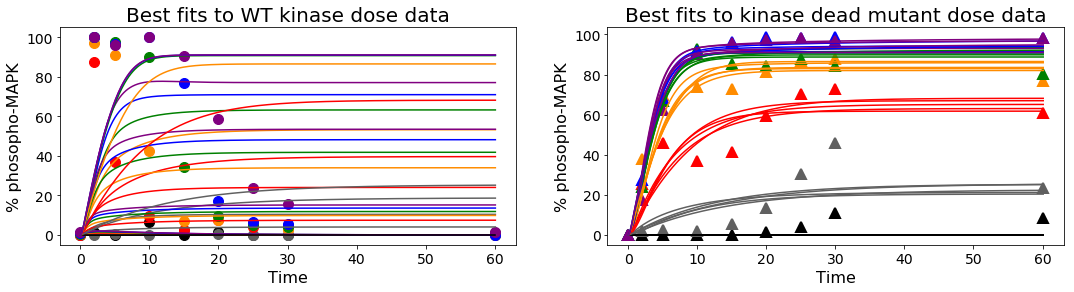

In [18]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 720x576 with 0 Axes>

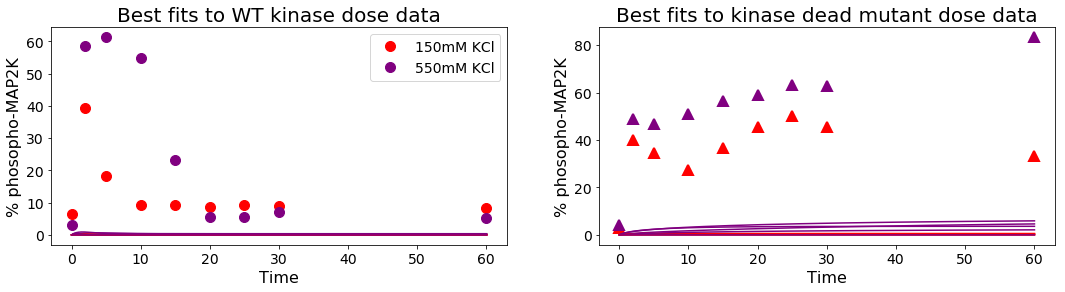

In [25]:
map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t, map2k_s] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants_map2k, initals, time)

In [26]:
pulse_s = [550000]
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t, pulse_s] 
plt_param_behaviors_pulse(hog1_pulse_data, pbs2_pulse_data, gen, idx_top, 5, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

NameError: name 'hog1_pulse_data' is not defined

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 720x576 with 0 Axes>

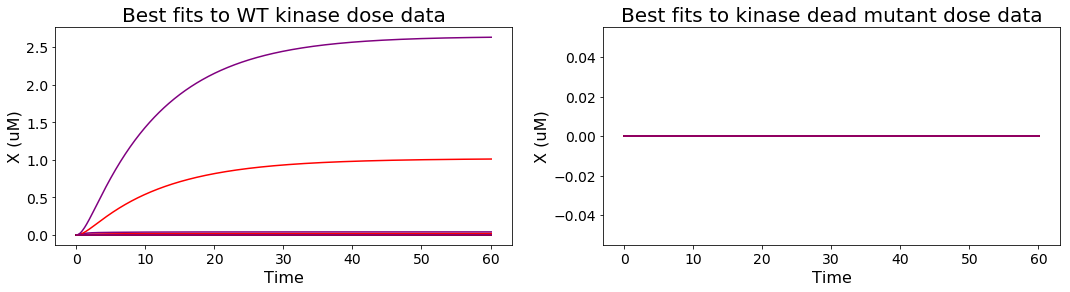

In [27]:
plt_X_behaviors(gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

<Figure size 864x576 with 0 Axes>

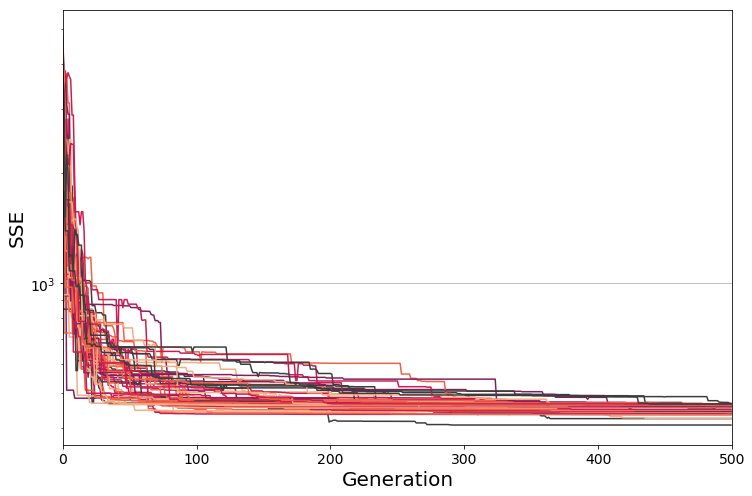

In [37]:
plt_mses_gen(gen,mse_aN_1D)

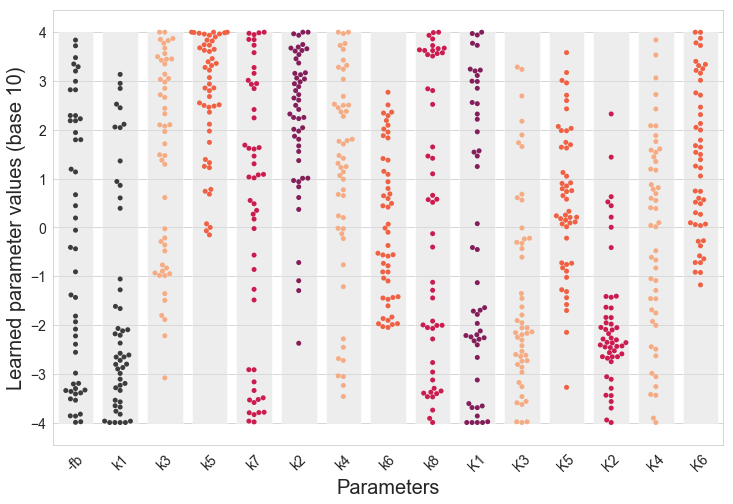

In [38]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

## A1

### Functions

In [252]:
def b3_a1_1D_X(initals,t,total_protein,sig,params, signal_fxn=None, signal_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, s = total_protein
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # Y_I = Y_t-Y
    if signal_fxn:
        sig = signal_fxn(t,sig,signal_params)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time, signal_fxn, signal_params):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_X, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time, signal_fxn, signal_params):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha_2, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(b3_a1_1D_X, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

In [ ]:
def signal_periodic(t_step, signal, period):
    if t_step == 0:
        s = 0
    elif t_step >= 60:
        s = 0
    elif t_step >= 30:
        s = 0
    elif np.floor(t_step / period) % 2 == 0:
        s =  signal
    else:
        s = 0
    return s

### Inputs

In [253]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/1_pass/181025_b3_1D_a1/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/linear_pulses/190118_1D_a1_map2k_pulse/'

run_name = 'b3_1D_a1'
gen = 250
runs = 1000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-8, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 2, 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, s] 

### Gather simulated data

In [254]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.02)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2811.179292329779
Mean MSE of top 5%: 3589.6811014945642


### Plot

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

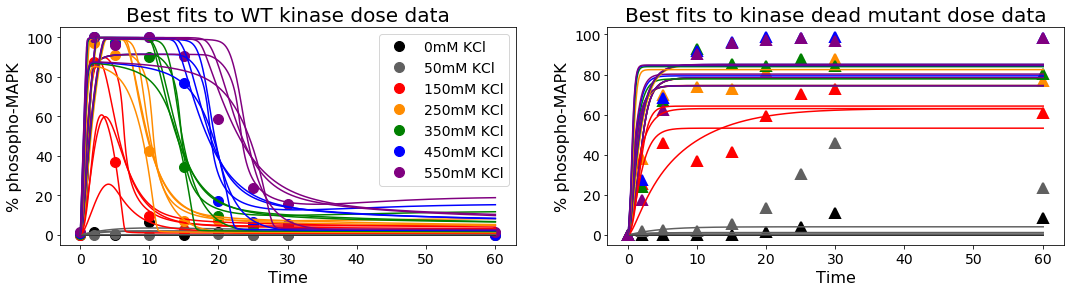

In [214]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

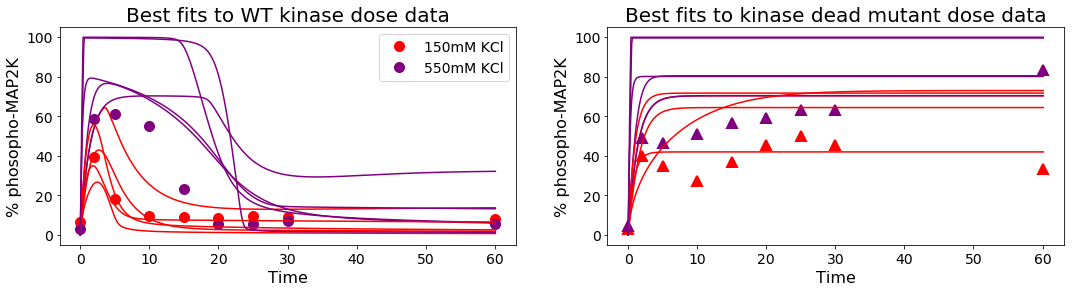

In [118]:
map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t, map2k_s] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants_map2k, initals, time)

<Figure size 864x576 with 0 Axes>

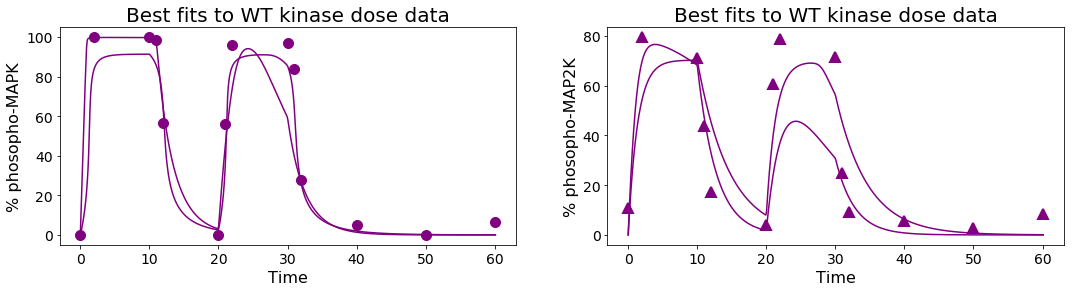

In [255]:
pulse_s = [550000]
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t, pulse_s] 
plt_param_behaviors_pulse(hog1_pulse_data, pbs2_pulse_data, gen, idx_top, 2, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

<Figure size 864x576 with 0 Axes>

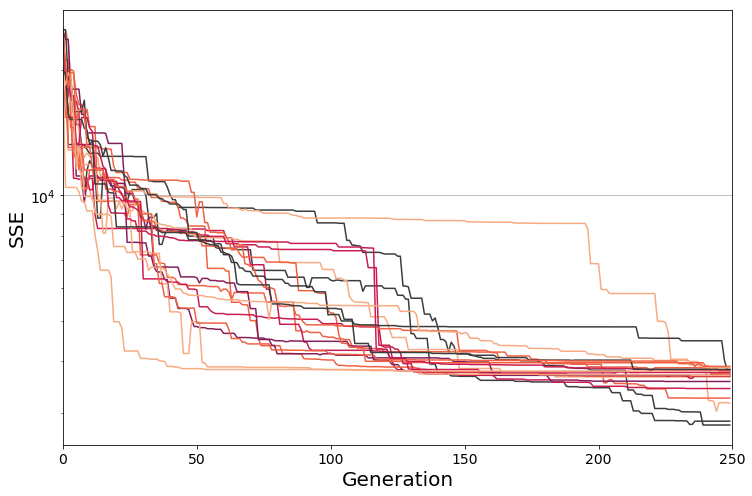

In [121]:
plt_mses_gen(gen,mse_a1_1D)

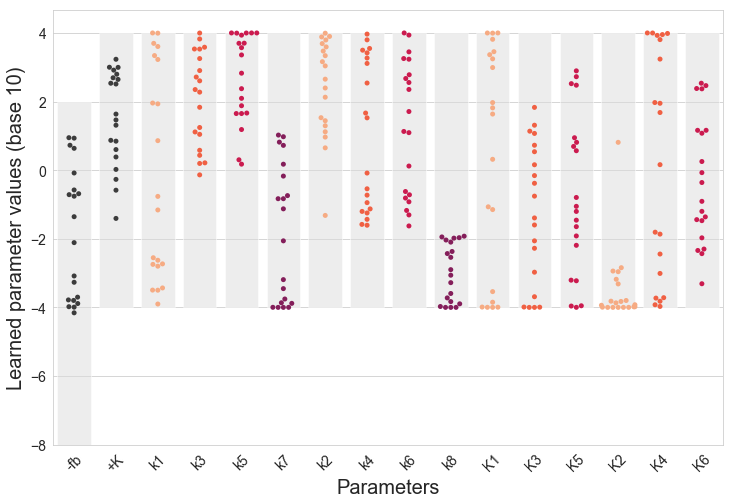

In [122]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

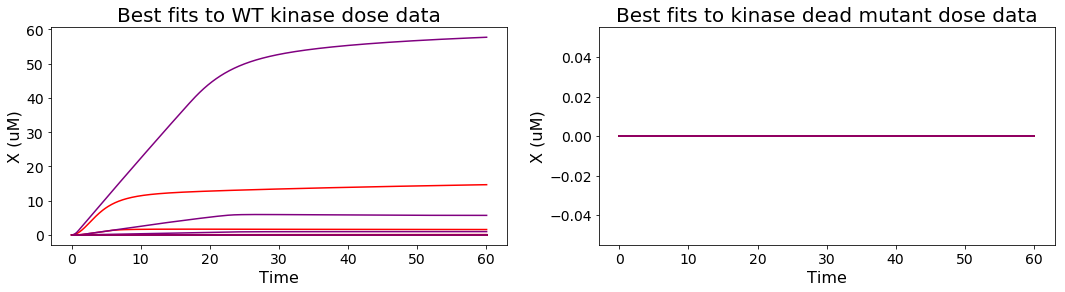

In [215]:
plt_X_behaviors(gen, idx_top, 5, params_from_file, 
                        params_constants_pulse, initals, time)

In [124]:
plt_X_behaviors_pulse(mapk_wt_data, map2k_wt_data, gen, idx_top, plt_top, params_from_file, params_constants, initals, time)

TypeError: plt_X_behaviors_pulse() takes 7 positional arguments but 9 were given

(array([ 12.,  47., 285., 208.,  93.,  74.,  91., 114.,  37.,  11.,   9.,
          1.,   0.,   0.,   1.]),
 array([ 1618.71432657,  2442.41918743,  3266.12404828,  4089.82890914,
         4913.53377   ,  5737.23863086,  6560.94349172,  7384.64835258,
         8208.35321343,  9032.05807429,  9855.76293515, 10679.46779601,
        11503.17265687, 12326.87751773, 13150.58237859, 13974.28723944]),
 <a list of 15 Patch objects>)

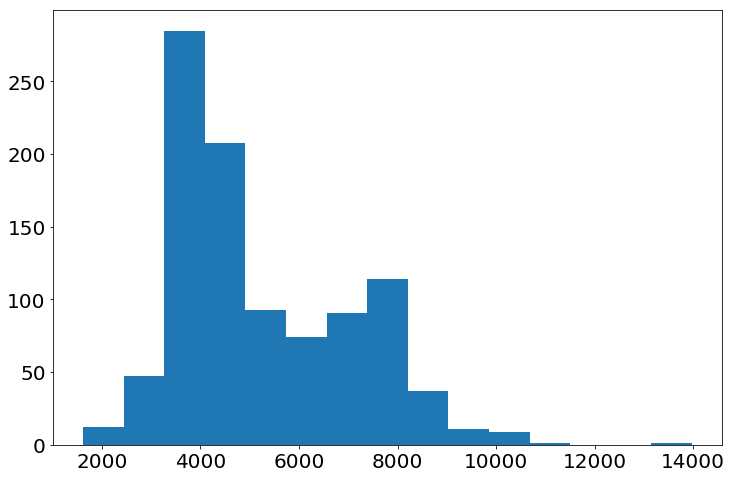

In [118]:
plt.hist(last_mses_a1_1D,bins=15,color='#1f77b4')

### Get Synth data

In [296]:
synth_params = get_synth_data_params(opt_data_mapk,wt_data_synth,top_params_a1_1D,20)
print(synth_params)
print(synth_params[9])
synth_params[9] = 2
print(synth_params)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.04207612020326186, 97.41482057416943, 0.0001077625232565047, 6.369102801529231, 270.50855738430846, 0.5676562200922737, 0.001565143596373113, 1138.7429398254433, 924.6175711390465, 0.00010113047939781751, 446.476538346608, 0.023309140716720002, 0.00010000002426322552, 0.0003313037452481998, 6109.017977613914, 8.285039918056604]
0.00010113047939781751
[0.04207612020326186, 97.41482057416943, 0.0001077625232565047, 6.369102801529231, 270.50855738430846, 0.5676562200922737, 0.001565143596373113, 1138.7429398254433, 924.6175711390465, 2, 446.476538346608, 0.023309140716720002, 0.00010000002426322552, 0.0003313037452481998, 6109.017977613914, 8.285039918056604]


#### Plotting

C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

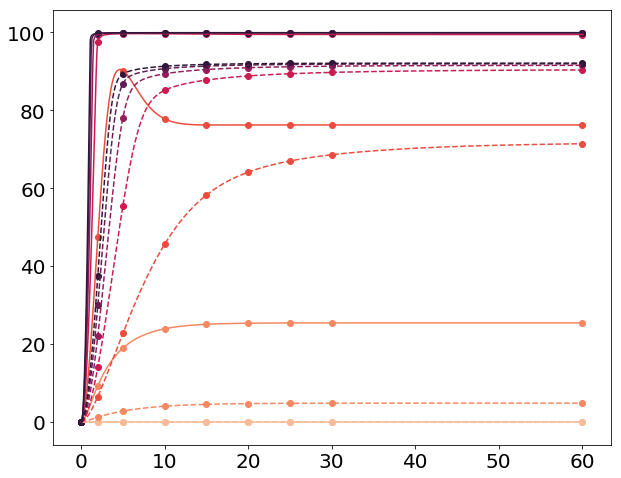

C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in 

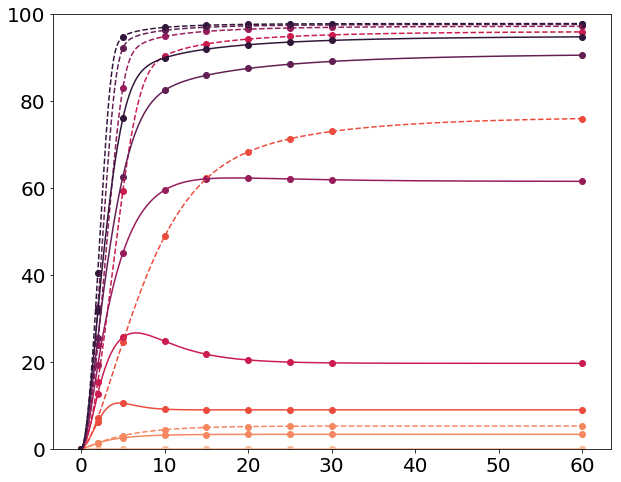

C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


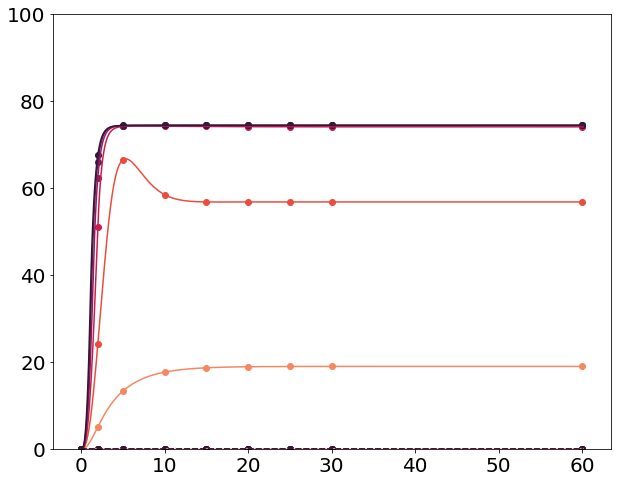

In [297]:
color_palette = sns.color_palette("rocket", 7)[::-1]

timesc = np.asarray([0,2,5,10,15,20,25,30,60])

plt.rcParams['figure.figsize'] = [10.0, 8.0]

synth_wt = []
synth_t100a = []
for idx, sig in enumerate(params_constants[-1]):
    data = simulate_wt_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,2]/params_constants[2]*100
    synth_wt.append(active[[timesc*10]])
    plt.plot(time, active, label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

    data = simulate_t100a_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,2]/params_constants[2]*100
    synth_t100a.append(active[[timesc*10]])
    plt.plot(time, active, '--', label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

plt.show()

synth_map2k = []
synth_map2k_t100a = []
for idx, sig in enumerate(params_constants[-1]):
    data = simulate_wt_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,1]/params_constants[1]*100
    synth_map2k.append(active[[timesc*10]])
    plt.plot(time, active, label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

    data = simulate_t100a_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,1]/params_constants[1]*100
    synth_map2k_t100a.append(active[[timesc*10]])
#     synth_t100a.append(data[:,2][[timesc*10]])
    plt.plot(time, active, '--', label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])
plt.ylim(0,100)
plt.show()

# synth_map2k = []
# synth_map2k_t100a = []
for idx, sig in enumerate(params_constants[-1]):
    data = simulate_wt_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,3]/params_constants[1]*100
#     synth_map2k.append(active[[timesc*10]])
    plt.plot(time, active, label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

    data = simulate_t100a_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,3]/params_constants[1]*100
#     synth_map2k_t100a.append(active[[timesc*10]])
    plt.plot(time, active, '--', label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])
plt.ylim(0,100)
plt.show()

#### Saving Synth Data

In [573]:
scorefxn_time_new = timesc
scorefxn_data_mapk = [synth_wt, synth_t100a]

scorefxn_arr = [scorefxn_time_new, scorefxn_data_mapk]
filename = 'C:/Users/sksuzuki/Desktop/killdevil/to/'+run_name+'_SYNTH.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))

scorefxn_data_map2k = [synth_wt, synth_t100a, synth_map2k, synth_map2k_t100a]
scorefxn_arr = [scorefxn_time_new, scorefxn_data_map2k]
filename = 'C:/Users/sksuzuki/Desktop/killdevil/to/'+run_name+'_map2k_SYNTH.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))

### Solve IVP

In [127]:
test2=params_constants[:-1]+[550000]
params_constants = test2
params = top_params[0]
def fart(t,y):
    MAP3K, MAP2K, MAPK, X = y
    MAP3K_t, MAP2K_t, MAPK_t, s = params_constants
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

# def wrapper(t,y):
#     return b3_a1_1D_X(initals, t, test2, top_params[0])
test3 = solve_ivp(fart, (0,5), initals, method='RK45', t_eval=[0,1,2])
print(len(test3.t))
print(test3.y[2])

3
[0.00000000e+00 4.80241218e+07 2.35998720e+14]


In [128]:
test3 = odeint(b3_a1_1D_X, initals, time, args=(test2, top_params[0]))
test3[:,2]

array([0.        , 0.00522535, 0.01892692, 0.03856053, 0.06193808,
       0.08702052, 0.11175835, 0.13405543, 0.15206671, 0.16495068,
       0.17339784, 0.17896271, 0.18294803, 0.18606182, 0.18862758,
       0.19080242, 0.19267768, 0.1943148 , 0.19575826, 0.19704159,
       0.19819068, 0.19922596, 0.20016374, 0.2010173 , 0.20179758,
       0.20251363, 0.20317301, 0.20378216, 0.20434652, 0.20487073,
       0.20535887, 0.2058144 , 0.20624037, 0.20663945, 0.20701396,
       0.207366  , 0.20769741, 0.20800979, 0.20830462, 0.20858321,
       0.20884673, 0.20909624, 0.20933269, 0.20955694, 0.20976978,
       0.20997195, 0.21016408, 0.21034677, 0.21052056, 0.21068594,
       0.21084341, 0.21099335, 0.21113617, 0.21127221, 0.21140183,
       0.21152532, 0.21164297, 0.21175504, 0.21186177, 0.21196339,
       0.21206012, 0.21215214, 0.21223965, 0.21232281, 0.21240177,
       0.21247671, 0.21254773, 0.21261497, 0.21267857, 0.21273861,
       0.21279521, 0.21284848, 0.21289849, 0.21294532, 0.21298

## A2

### Functions

In [242]:
def b3_a2_1D_X(initals,t,total_protein,sig,params, signal_fxn=None, signal_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, s = total_protein
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # Y_I = Y_t-Y
    if signal_fxn:
        sig = signal_fxn(t,sig,signal_params)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time, signal_fxn, signal_params):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a2_1D_X, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time, signal_fxn, signal_params):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(b3_a2_1D_X, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

### Inputs

In [ ]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/1_pass/181025_b3_1D_a1/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/linear_pulses/190122_1D_a2_map2k_pulse/'

run_name = 'b3_1D_a2'
gen = 250
runs = 1000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-8, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 2, 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, s] 

### Gather simulated data

In [243]:
idx_top, top_params_a2_1D, top, plt_top, new_params, params_from_file, mse_a2_1D, last_mses_a2_1D = gather_simulated_data(folder, gen, runs, 0.02)
df_top_params = pd.DataFrame(top_params_a2_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2631.2494834535732
Mean MSE of top 5%: 3225.544591225894


### Plot

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

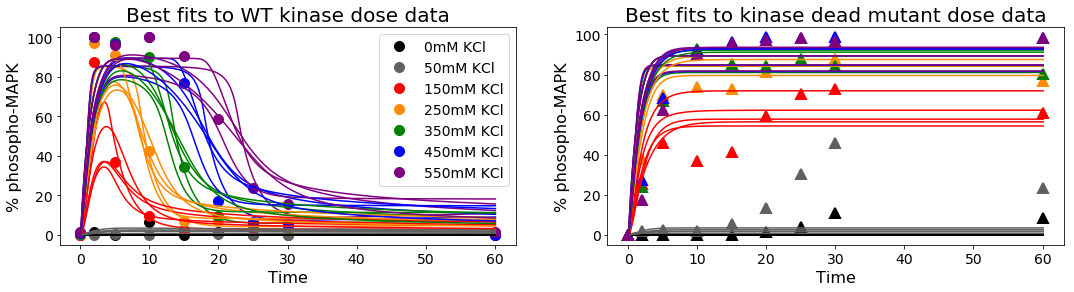

In [206]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

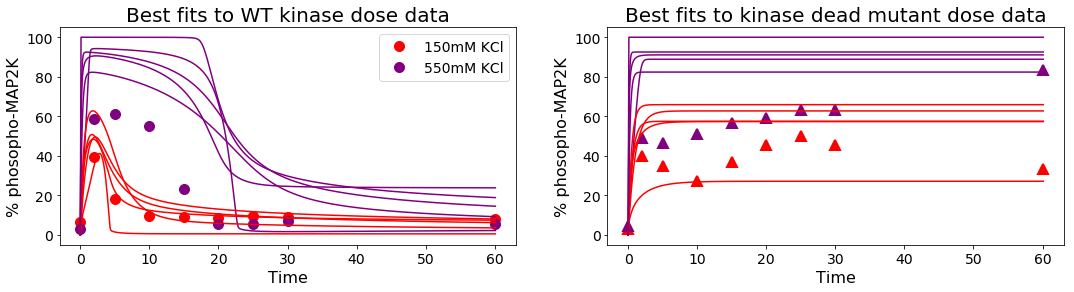

In [207]:
map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t, map2k_s] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants_map2k, initals, time)

<Figure size 864x576 with 0 Axes>

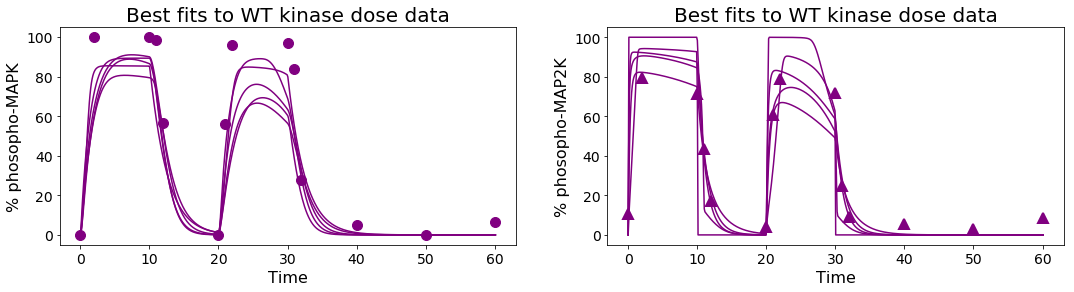

In [208]:
pulse_s = [550000]
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t, pulse_s] 
plt_param_behaviors_pulse(hog1_pulse_data, pbs2_pulse_data, gen, idx_top, 5, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

<Figure size 864x576 with 0 Axes>

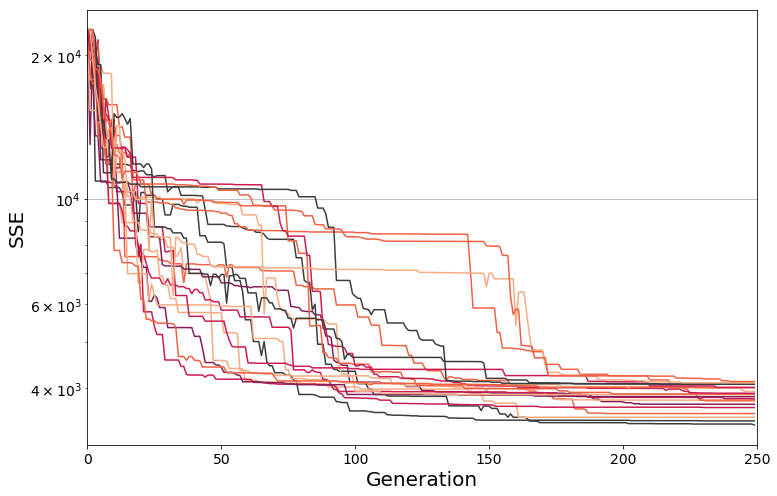

In [138]:
plt_mses_gen(gen,mse_a2_1D)

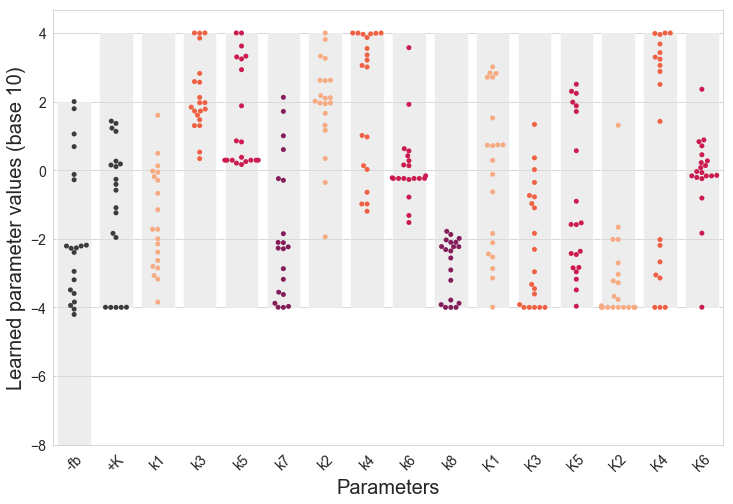

In [139]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

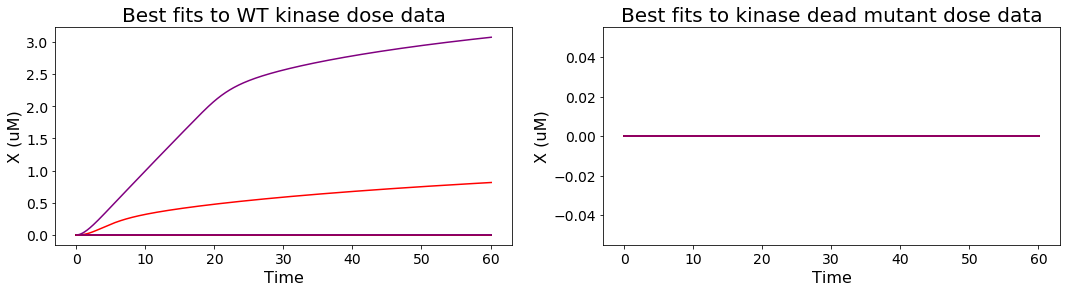

In [209]:
plt_X_behaviors(gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

In [128]:
plt.hist(last_mses_a2_1D,bins=15,color='#1f77b4')

NameError: name 'last_mses' is not defined

### Get Synth data

In [49]:
synth_params = get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,20)
print(synth_params)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.03043541211475528, 0.0417328039966076, 1000.3013688680286, 0.3743250891795353, 716.7888488125199, 0.10095887221951434, 3421.2588719050245, 0.03774532133833416, 78.41891404895863, 0.003860425229538357, 525.0235100174281, 0.00010000000025448281, 0.00031258888785773545, 0.0009631839116063782, 0.04176259210214304, 0.638114770847629]


#### Plotting

C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

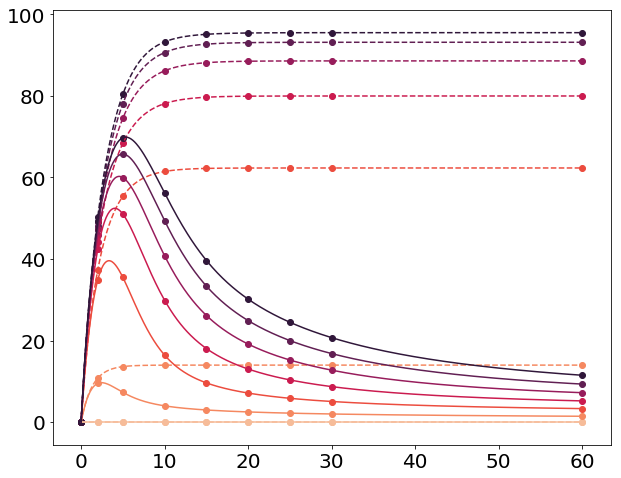

C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in 

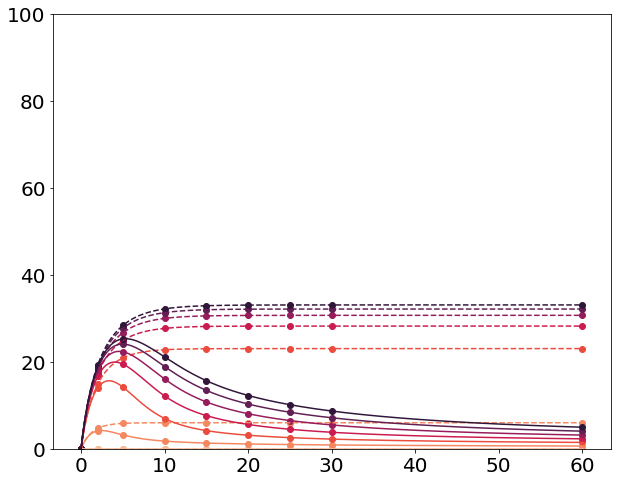

In [578]:
color_palette = sns.color_palette("rocket", 7)[::-1]

timesc = np.asarray([0,2,5,10,15,20,25,30,60])

plt.rcParams['figure.figsize'] = [10.0, 8.0]

synth_wt = []
synth_t100a = []
for idx, sig in enumerate(params_constants[-1]):
    data = simulate_wt_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,2]/params_constants[2]*100
    synth_wt.append(active[[timesc*10]])
    plt.plot(time, active, label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

    data = simulate_t100a_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,2]/params_constants[2]*100
    synth_t100a.append(active[[timesc*10]])
    plt.plot(time, active, '--', label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

plt.show()

synth_map2k = []
synth_map2k_t100a = []
for idx, sig in enumerate(params_constants[-1]):
    data = simulate_wt_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,1]/params_constants[1]*100
    synth_map2k.append(active[[timesc*10]])
    plt.plot(time, active, label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

    data = simulate_t100a_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,1]/params_constants[1]*100
    synth_map2k_t100a.append(active[[timesc*10]])
#     synth_t100a.append(data[:,2][[timesc*10]])
    plt.plot(time, active, '--', label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])
plt.ylim(0,100)
plt.show()

#### Saving Synth Data

In [579]:
scorefxn_time_new = timesc
scorefxn_data_mapk = [synth_wt, synth_t100a]

scorefxn_arr = [scorefxn_time_new, scorefxn_data_mapk]
filename = 'C:/Users/sksuzuki/Desktop/killdevil/to/'+run_name+'_SYNTH.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))

scorefxn_data_map2k = [synth_wt, synth_t100a, synth_map2k, synth_map2k_t100a]
scorefxn_arr = [scorefxn_time_new, scorefxn_data_map2k]
filename = 'C:/Users/sksuzuki/Desktop/killdevil/to/'+run_name+'_map2k_SYNTH.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))

## A3

### Functions

In [ ]:
def b3_a3_1D_X(initals,t,total_protein,sig,params, signal_fxn=None, signal_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, s = total_protein
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # Y_I = Y_t-Y
    if signal_fxn:
        sig = signal_fxn(t,sig,signal_params)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1+alpha*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time, signal_fxn, signal_params):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a3_1D_X, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time, signal_fxn, signal_params):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(b3_a3_1D_X, inits, time, args=(total_protein, sig, learned_params, signal_fxn, signal_params))

    return odes

### Inputs

In [ ]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/1_pass/181025_b3_1D_a1/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/linear_pulses/190122_1D_a3_map2k_pulse/'

run_name = 'b3_1D_a2'
gen = 250
runs = 1000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-8, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 2, 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, s] 

### Gather simulated data

In [238]:
idx_top, top_params_a3_1D, top, plt_top, new_params, params_from_file, mse_a3_1D, last_mses_a3_1D = gather_simulated_data(folder, gen, runs, 0.02)
df_top_params = pd.DataFrame(top_params_a3_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2631.2494834535732
Mean MSE of top 5%: 3225.544591225894


### Plot

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

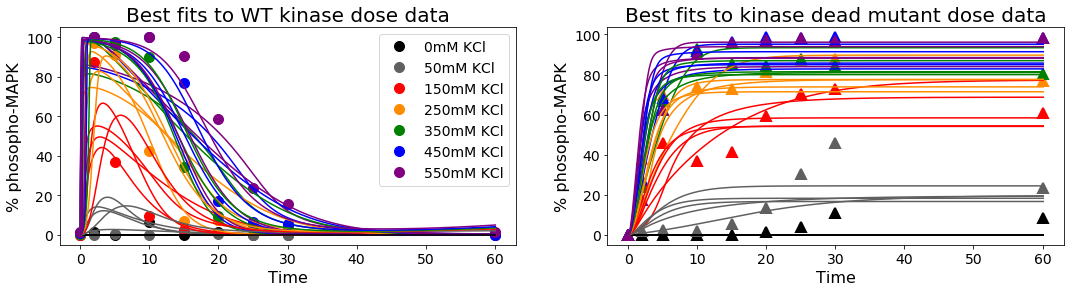

In [192]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

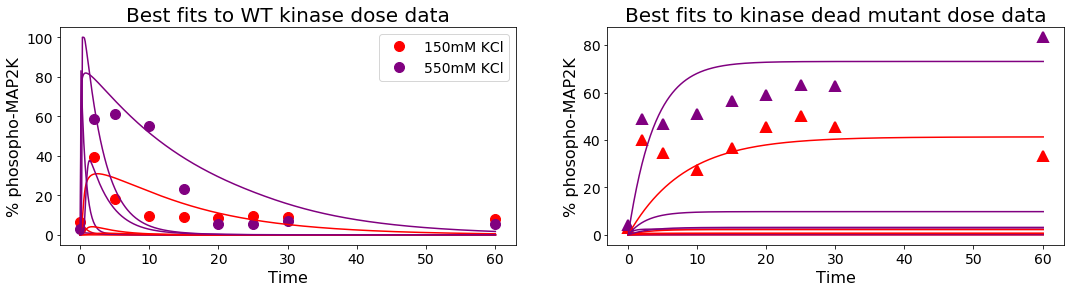

In [193]:
map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t, map2k_s] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants_map2k, initals, time)

<Figure size 864x576 with 0 Axes>

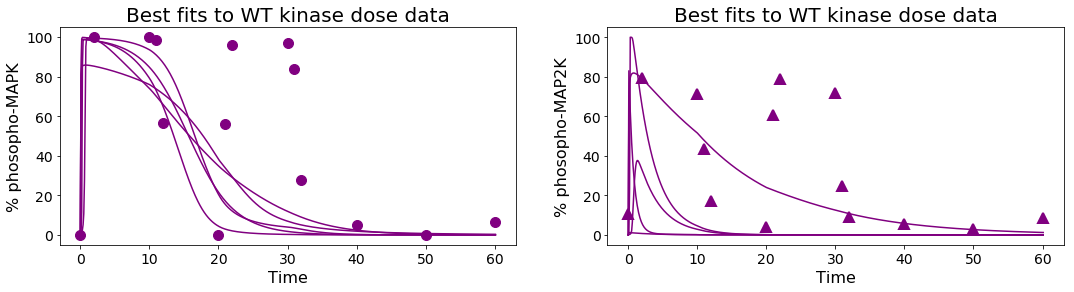

In [195]:
pulse_s = [550000]
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t, pulse_s] 
plt_param_behaviors_pulse(hog1_pulse_data, pbs2_pulse_data,  gen, idx_top, 5, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

<Figure size 864x576 with 0 Axes>

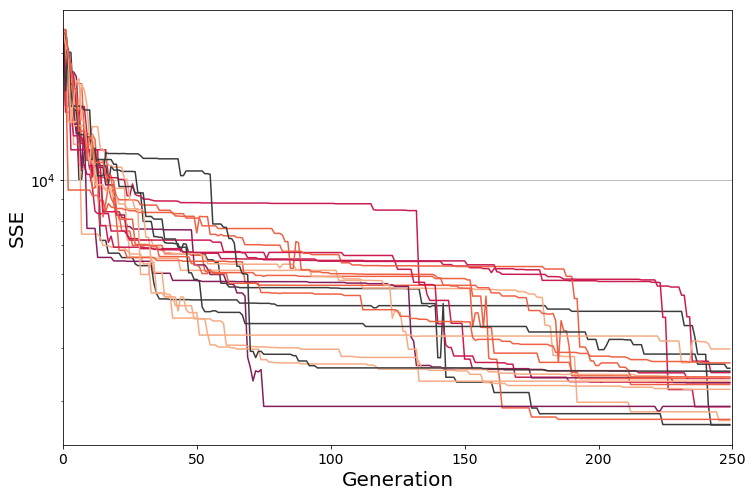

In [151]:
plt_mses_gen(gen,mse_a3_1D)

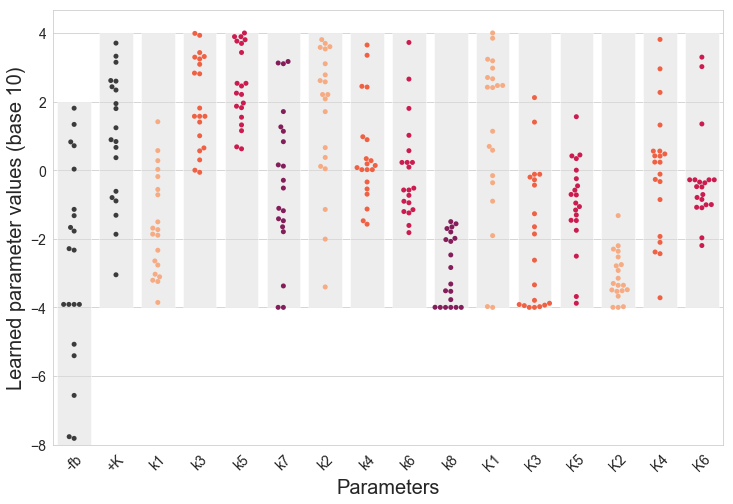

In [152]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

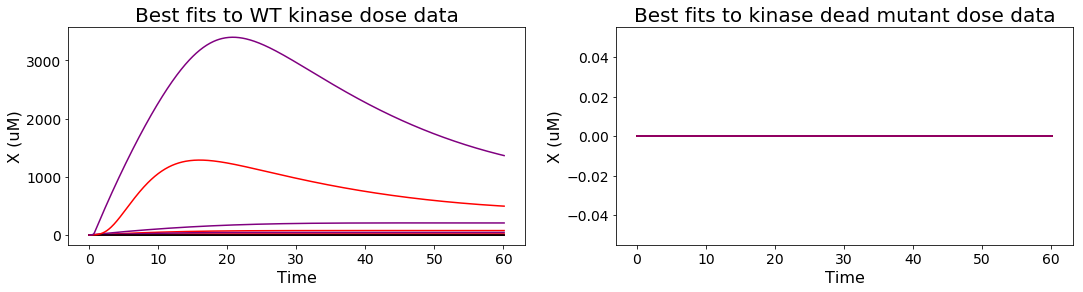

In [239]:
plt_X_behaviors(gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

### Get Synth data

In [17]:
synth_params = get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,20)
print(synth_params)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.4731614187515633e-05, 9999.991813357154, 0.0011335548854895436, 9999.99999289708, 2438.5185506917014, 339.62212256030864, 4.317287169165386, 0.24936410626079056, 9947.169579078321, 0.00010001137720955296, 9243.430162078077, 0.02231479883072405, 0.006340336311866502, 0.00021884302168209783, 1.528239324584821, 256.91831226630086]


#### Plotting

C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

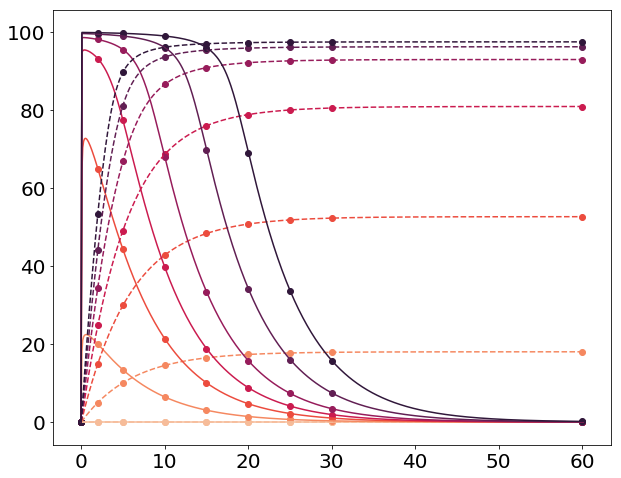

C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\sksuzuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in 

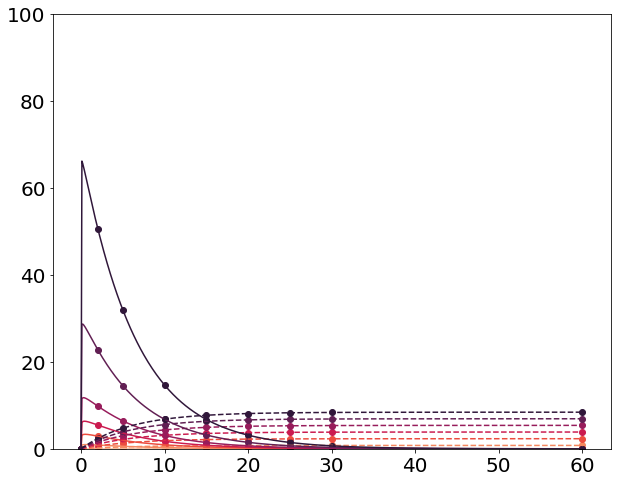

In [584]:
color_palette = sns.color_palette("rocket", 7)[::-1]

timesc = np.asarray([0,2,5,10,15,20,25,30,60])

plt.rcParams['figure.figsize'] = [10.0, 8.0]

synth_wt = []
synth_t100a = []
for idx, sig in enumerate(params_constants[-1]):
    data = simulate_wt_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,2]/params_constants[2]*100
    synth_wt.append(active[[timesc*10]])
    plt.plot(time, active, label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

    data = simulate_t100a_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,2]/params_constants[2]*100
    synth_t100a.append(active[[timesc*10]])
    plt.plot(time, active, '--', label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

plt.show()

synth_map2k = []
synth_map2k_t100a = []
for idx, sig in enumerate(params_constants[-1]):
    data = simulate_wt_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,1]/params_constants[1]*100
    synth_map2k.append(active[[timesc*10]])
    plt.plot(time, active, label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])

    data = simulate_t100a_experiment(initals, params_constants[:-1]+[sig], synth_params, time)
    active = data[:,1]/params_constants[1]*100
    synth_map2k_t100a.append(active[[timesc*10]])
#     synth_t100a.append(data[:,2][[timesc*10]])
    plt.plot(time, active, '--', label=str(sig)+' T100A active', color=color_palette[idx])
    plt.scatter(timesc, active[[timesc*10]], color=color_palette[idx])
plt.ylim(0,100)
plt.show()

#### Saving Synth Data

In [585]:
scorefxn_time_new = timesc
scorefxn_data_mapk = [synth_wt, synth_t100a]

scorefxn_arr = [scorefxn_time_new, scorefxn_data_mapk]
filename = 'C:/Users/sksuzuki/Desktop/killdevil/to/'+run_name+'_SYNTH.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))

scorefxn_data_map2k = [synth_wt, synth_t100a, synth_map2k, synth_map2k_t100a]
scorefxn_arr = [scorefxn_time_new, scorefxn_data_map2k]
filename = 'C:/Users/sksuzuki/Desktop/killdevil/to/'+run_name+'_map2k_SYNTH.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))

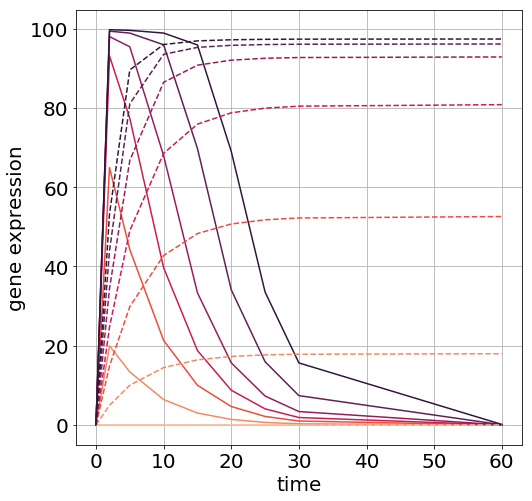

In [591]:
filename = 'C:/Users/sksuzuki/Desktop/killdevil/to/map2k_synthdata/b3_1D_a3_map2k_SYNTH.pickled'

scorefxn_arr = pickle.load(open(filename, 'rb'))
scorefxn_time, scorefxn_data = scorefxn_arr 

fig, axes = plt.subplots(1, 1, figsize=(8,8))
# use_consistent_colors = ['b','g']
for strain,dash in zip(scorefxn_data, ['-','--','-.','.-']):
    for idx, exp in enumerate(strain):
        axes.plot(scorefxn_time, exp, dash, markersize=10,color=color_palette[idx])
#     print(len(strain))
axes.set_ylabel('gene expression', fontsize=20)
axes.set_xlabel('time', fontsize=20)
axes.grid()
plt.show()

### Lab meeting

#### individ

In [ ]:
colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

color_palette = sns.color_palette(colors)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
for i, params in enumerate(top_params[17:18]):#17:18
#     beta_1, beta_2, alpha, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, kn, kc = params
#     params = beta_1, beta_2, 0, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, 0, kc
    #plot real data:
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
        data = odeint(b3_a3_1D_X, initals, time, args=(params_constants[:-1]+[signal], params))
        active = data[:,2]/params_constants[2]*100
        ax1.plot(time, active, label=str(int(signal/1000))+'mM KCl', color=color_palette[idx])

#     plt.title(f'Param set {i}')
    ax1.set_title('One simulation fit to WT data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('% ppHog1')
#     plt.show()
    ax1.set_xlim(0,32)
    ax1.set_ylim(0,105)
    ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/wt_individ.png",dpi=150, bbox_inches='tight')
    plt.clf()


In [ ]:
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))

for i, params in enumerate(top_params[17:18]):#17:18
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        plt.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
#         plt.plot(time, data[:,4], dashes=[2, 2], label=str(signal)+' X')
        data = simulate_t100a_experiment(initals, params_constants[:-1]+[signal], params, time)
        active = data[:,2]/params_constants[2]*100
        plt.plot(time, active, label=str(int(signal/1000))+'mM KCl', dashes= [4,2], color=color_palette[idx])
#         plt.plot(time, data[:,3], label=str(signal)+' MAPKn')
#     plt.title(f'Param set {i}')
    ax2.set_title('One simulation fit to Hog1 T100A + Inhib data')
    ax2.set_xlim(0,32)
    ax2.set_ylim(0,105)
    ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('% ppHog1')
#     plt.ylim(0,100)
#     plt.show()
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/t100a_individ.png",dpi=150, bbox_inches='tight')

In [ ]:
fig, (ax3) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
for i in range(0,gen+1,5):
    #plot3 
    # sns.color_palette(palette_husl)
#     pal = sns.color_palette("Greys", 20)[10:]
    ax3.set_xlabel('Generation', fontsize=20)
    # ax2.set_ylabel('Sum of MSE', fontsize=20)
    # ax2.set_xlim([0,gen])
    # ax2.set_ylim([10**3,10**5])
    pal = sns.set_palette(pal)
    for idx in idx_top[17:18]:
        ax3.semilogy([x for x in range(i)], mse[idx][:i], color='black')
    #     ax3.plot([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_xlim(0,505)
    ax3.set_ylim(800,20000)
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    # ax3.yaxis.set_minor_locator(locmin)
    # ax3.yaxis.set_minor_formatter(mticker.NullFormatter())
#     plt.show()
#     plt.ioff()
plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mse_individ.png",dpi=150)
plt.show()

In [ ]:
labelnames = ['-fb', '+fb',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 'K7',
              'K2', 'K4', 'K6', 'K8'
                ]

rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e','#3c3c3c'] + rocket[::-1][:4]*4
param_col = sns.set_palette(colors)
all_top_params = [params_from_file[x] for x in idx_top]
    
# for i in range(0,gen+1,5):
plt.clf()
top_params = [all_top_params[x][gen] for x in range(100)]
df_top_params = pd.DataFrame(top_params[17:18])
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

fig, (ax4) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))


ax4.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
ax4 = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M, color=param_col, size=10)
ax4.set_xticklabels(labelnames,rotation=45)
#     ax.set_yscale("log")
#     ax.set_ylim(0.00001,100000)
#     ax4.set_xticks(locs)
#     plt.xticklabels(labelnames, fontsize=18, rotation=90)
ax4.set_xlabel('Parameters', fontsize=20)
ax4.set_ylabel('Learned parameter values (base 10)', fontsize=20)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax4.yaxis.grid(True)
# plt.show()
plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/param_individ.png",dpi=150)
#     plt.ioff()

#### gifs

In [ ]:
colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

pal = sns.color_palette(colors)
sns.palplot(pal)

In [ ]:
dt = 0.1
steps = 300
time = np.linspace(0,dt*steps,steps)

import warnings
warnings.filterwarnings(action='once')

for i in range(0,gen+1,5):
    plt.clf()


    # with sns.axes_style("whitegrid"):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

    pal = sns.color_palette(colors)

    # plot 1
    title_text = 'Gen ' + str(i) + ' fit to WT'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    # color_palette = sns.color_palette("rocket", 6)[::-1]


    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
    # unstable_wt = 0
    # unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][i]
        for idx, sig in enumerate(params_constants[-1]):
            params_c = params_constants[:-1]+[sig]
            data = simulate_wt_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=pal[idx])
    #         else:
    #             unstable_wt += 1
    #             unstable_t100a += 1
    # print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    # print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    for idx, wt_data in enumerate(mapk_wt_data):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=pal[idx])

    ax1.set_xlim(0,32)
    ax1.set_ylim(0,105)
    ax1.yaxis.grid(True)
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/fits/wt/"+str(i)+".png",dpi=150)
    plt.ioff()


In [ ]:
warnings.filterwarnings(action='once')

for i in range(0,gen+1,5):
    plt.clf()


    # with sns.axes_style("whitegrid"):
    fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
        # with sns.axes_style("whitegrid"):
    colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

    pal = sns.color_palette(colors)

    # plot 2
    title_text = 'Gen ' + str(i) +  ' fit to T100A + inhib'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=20)

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
    # unstable_wt = 0
    # unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][i]
        for idx, sig in enumerate(params_constants[-1]):
            params_c = params_constants[:-1]+[sig]
    #             unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=pal[idx])
    #         else:
    #             unstable_t100a += 1


    for idx, t100a_data in enumerate(mapk_t100a_data):
        ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=pal[idx])
    ax2.set_xlim(0,32)
    ax2.set_ylim(0,105)
    ax2.yaxis.grid(True)
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/fits/t100a/"+str(i)+".png",dpi=150)
    plt.ioff()

In [ ]:
for i in range(0,gen+1,5):
    plt.clf()
    fig, (ax3) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    #plot3 
    # sns.color_palette(palette_husl)
    pal = sns.color_palette("Greys", 20)[10:]
    ax3.set_xlabel('Generation', fontsize=20)
    # ax2.set_ylabel('Sum of MSE', fontsize=20)
    # ax2.set_xlim([0,gen])
    # ax2.set_ylim([10**3,10**5])
    pal = sns.set_palette(pal)
    for idx in idx_top:
        ax3.semilogy([x for x in range(i)], mse[idx][:i])
    #     ax3.plot([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_xlim(0,505)
    ax3.set_ylim(800,20000)
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    # ax3.yaxis.set_minor_locator(locmin)
    # ax3.yaxis.set_minor_formatter(mticker.NullFormatter())
#     plt.show()
#     plt.ioff()
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mse_gen/"+str(i)+".png",dpi=150)
plt.clf()

In [ ]:
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e','#3c3c3c'] + rocket[::-1][:4]*4
param_col = sns.set_palette(colors)
all_top_params = [params_from_file[x] for x in idx_top]
    
for i in range(0,gen+1,5):
    plt.clf()
    top_params = [all_top_params[x][i] for x in range(100)]
    df_top_params = pd.DataFrame(top_params)
    df_top_params.columns = labelnames
    df_top_params_log = df_top_params.apply(np.log10)
    df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

    fig, (ax4) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    

    ax4.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
    ax4 = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M, color=param_col)
    ax4.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
    ax4.set_xlabel('Parameters', fontsize=20)
    ax4.set_ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax4.yaxis.grid(True)
#     plt.show()
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/params_ranges/"+str(i)+".png",dpi=150)
    plt.ioff()

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

# Plot MSE vs. % of top fits

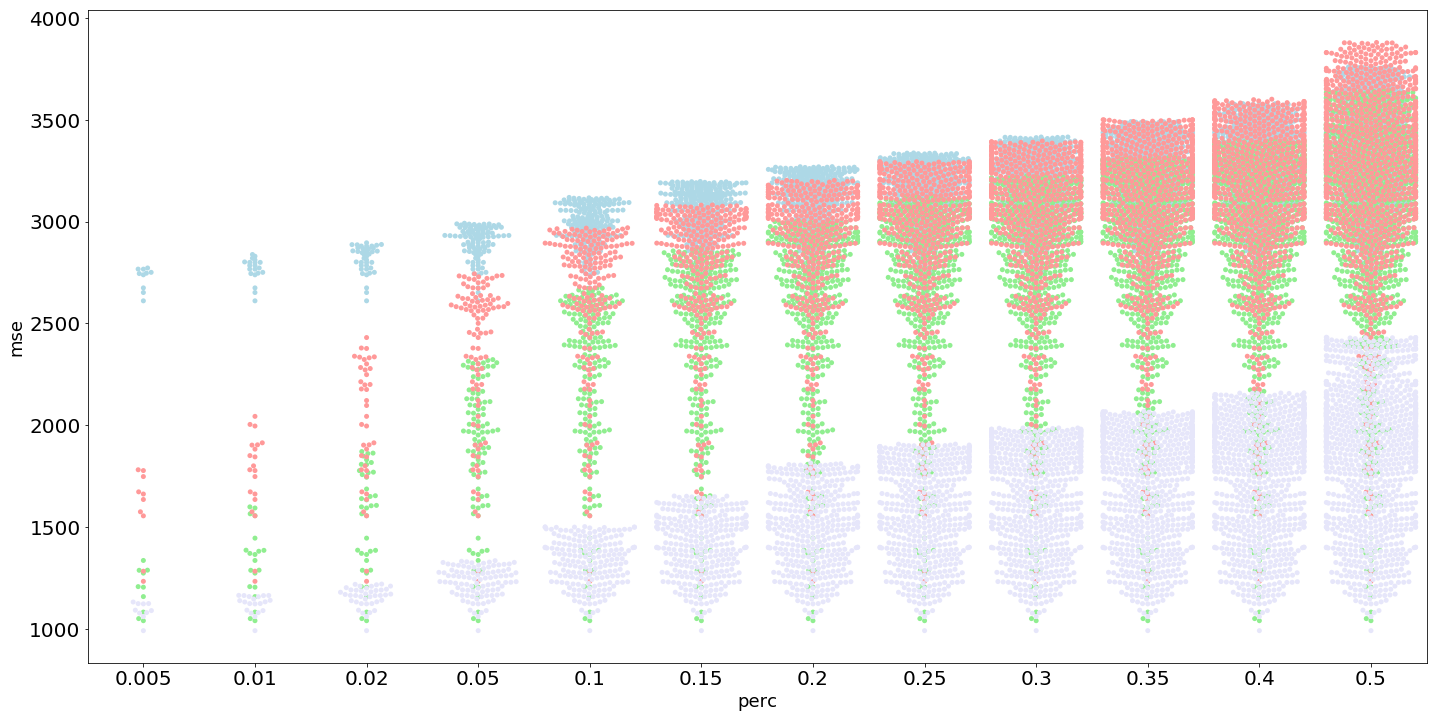

In [223]:
# mses_aN_1D_df = 

# percs = []
def get_mse_df(mses):
    sorted_mses = np.sort(mses)
    df = {'perc':[],'mse':[]}
    for p in [0.5,1,2,5,10,15,20,25,30,35,40,50]:
        perc = p/100
    #     percs.append(perc)
        top = round(perc*len(sorted_mses))
    #     df_ = {'perc': np.repeat(perc,top), 'mse': sorted_mses[:top]}
        df['perc'].append(np.repeat(perc,top))
        df['mse'].append(sorted_mses[:top])
    perc = np.concatenate(df['perc'],axis=0)
    mse = [x for y in df['mse'] for x in y]
    df = {'perc': perc,'mse':mse}
    df = pd.DataFrame(df)
    return df

mses_aN_1D_df = get_mse_df(last_mses_aN_1D)
mses_a1_1D_df = get_mse_df(last_mses_a1_1D)
mses_a2_1D_df = get_mse_df(last_mses_a2_1D)
mses_a3_1D_df = get_mse_df(last_mses_a3_1D)
# df.head()
# fig, ax = sns.subplots()
sns.swarmplot(x='perc',y='mse', data = mses_aN_1D_df, color='lightblue')
sns.swarmplot(x='perc',y='mse', data = mses_a1_1D_df, color='lightgreen')
sns.swarmplot(x='perc',y='mse', data = mses_a2_1D_df, color='#ff9999')
sns.swarmplot(x='perc',y='mse', data = mses_a3_1D_df, color='#E6E6FA')


# Clustering

In [351]:
cluster_marker=pd.Series()
for x in range(21):
    _marker = df_params_values['cluster']
    cluster_marker = cluster_marker.append(_marker)
_range = [x for x in range(2100 )]
cluster_marker.index = _range
data_swarm_cluster = df_top_params_log_M.copy()
data_swarm_cluster['cluster'] = cluster_marker


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


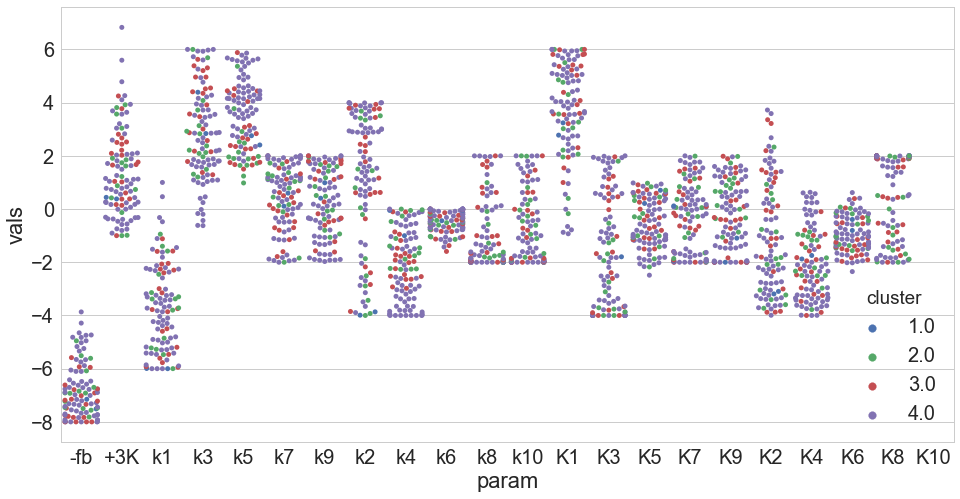

In [352]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
with sns.axes_style("whitegrid"):
    x = sns.swarmplot(x='param',y='vals', data = data_swarm_cluster, hue='cluster')

# Plot all MSEs

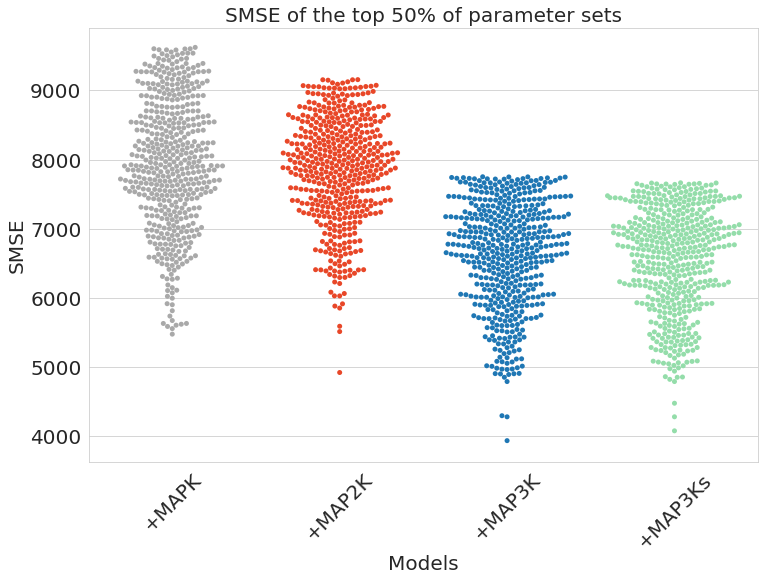

In [432]:
# last_mses_a1_1D_branch
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_a1_1D_branch, last_mses_a2_1D_branch, last_mses_a3_1D_branch, last_mses_a3s_1D_branch]        
plot_mses(['+MAPK', '+MAP2K', '+MAP3K', '+MAP3Ks'], mses, 0.5, colors, '0D')

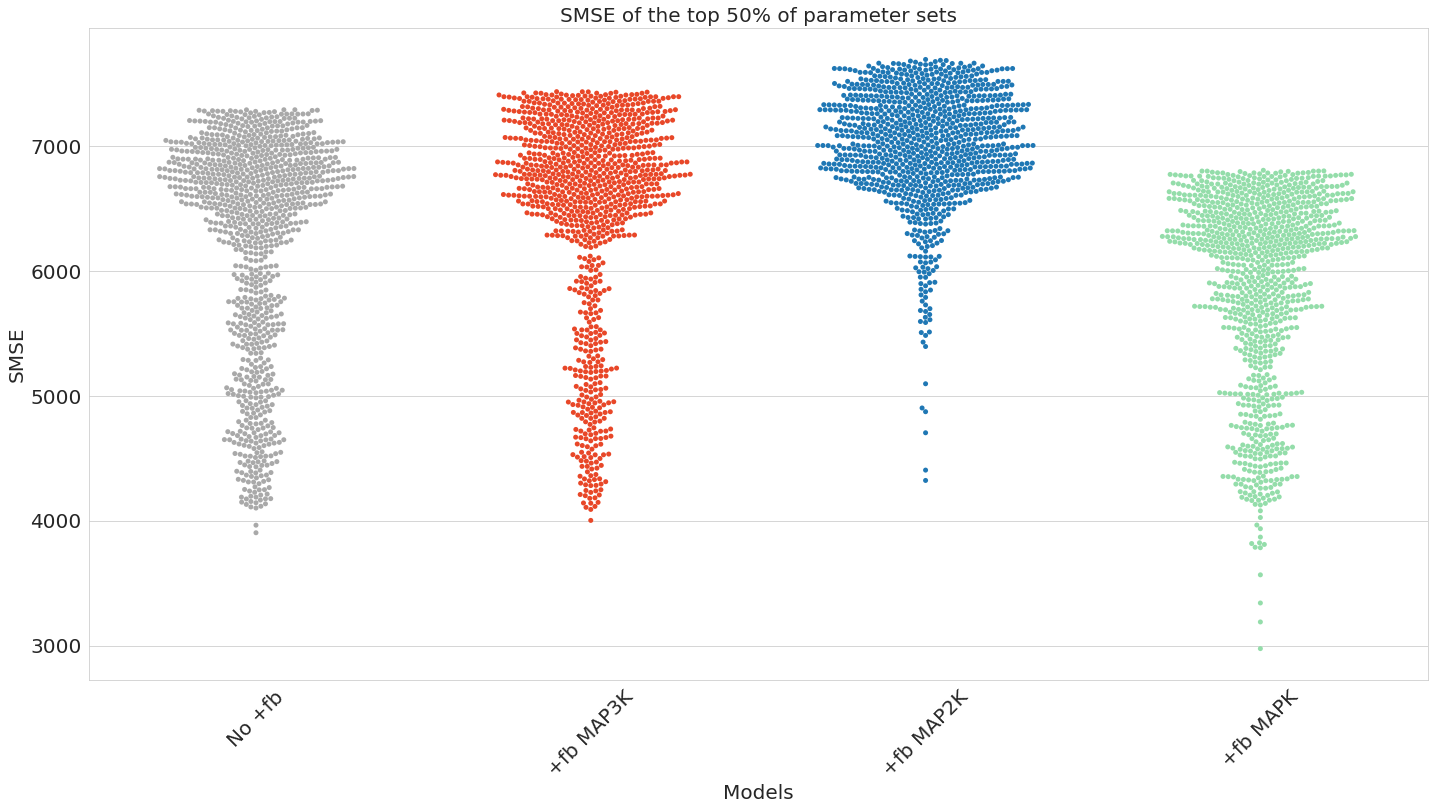

In [241]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_aN_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '0D')

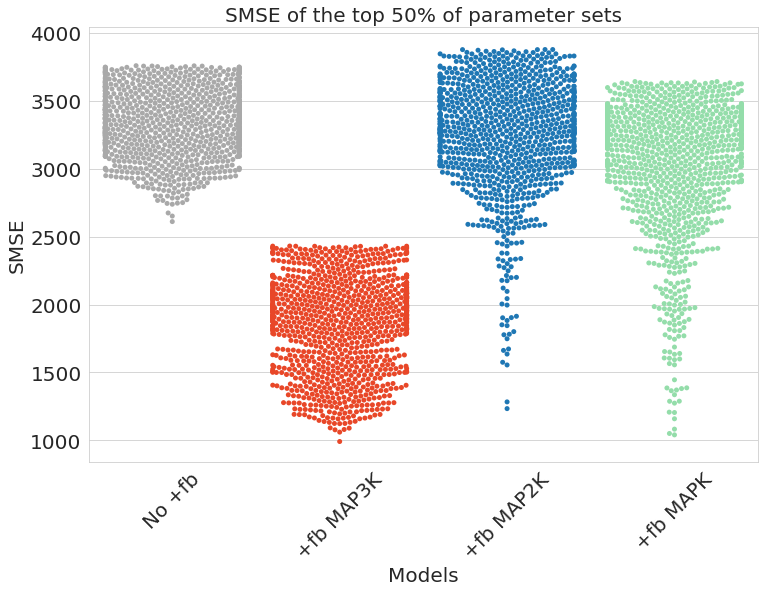

In [162]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_aN_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '1D')

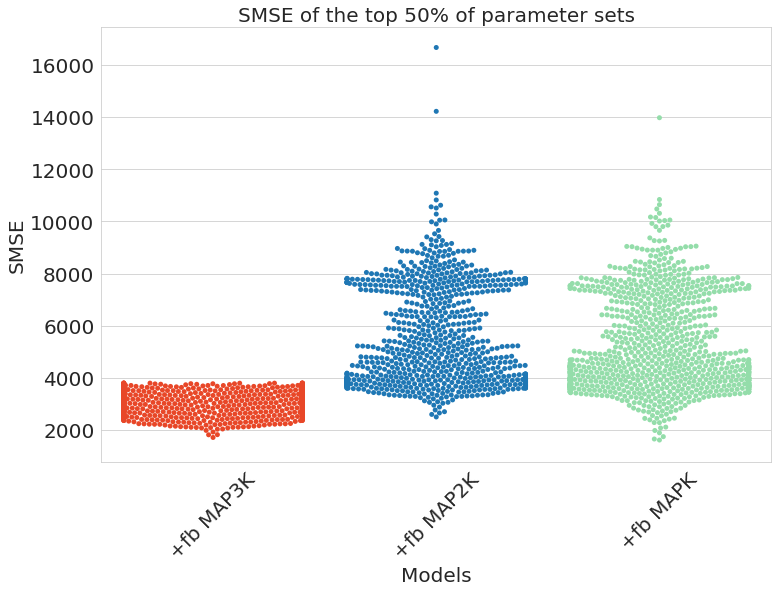

In [147]:
colors = ['#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '1D')

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

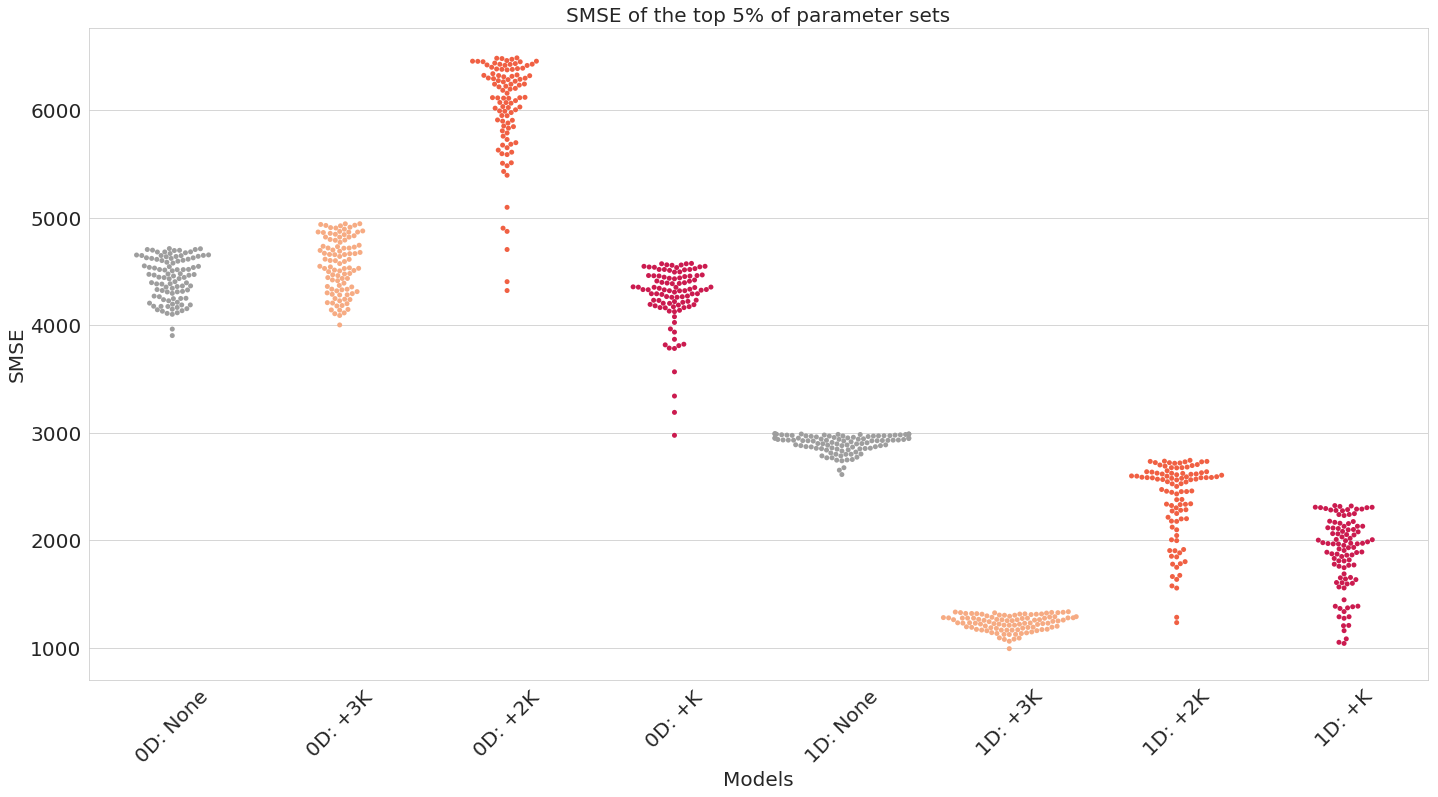

In [239]:
plt.rcParams['figure.figsize'] = [24.0, 12.0]
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [last_mses_aN_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D, 
        last_mses_aN_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D] 
#         last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['0D: None', '0D: +3K', '0D: +2K', '0D: +K',
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K'],
#            '2D: None', '2D: +3K', '2D: +2K', '2D: +K'],
          mses, 0.05, colors,'mses_all')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mses_all.png",dpi=300)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


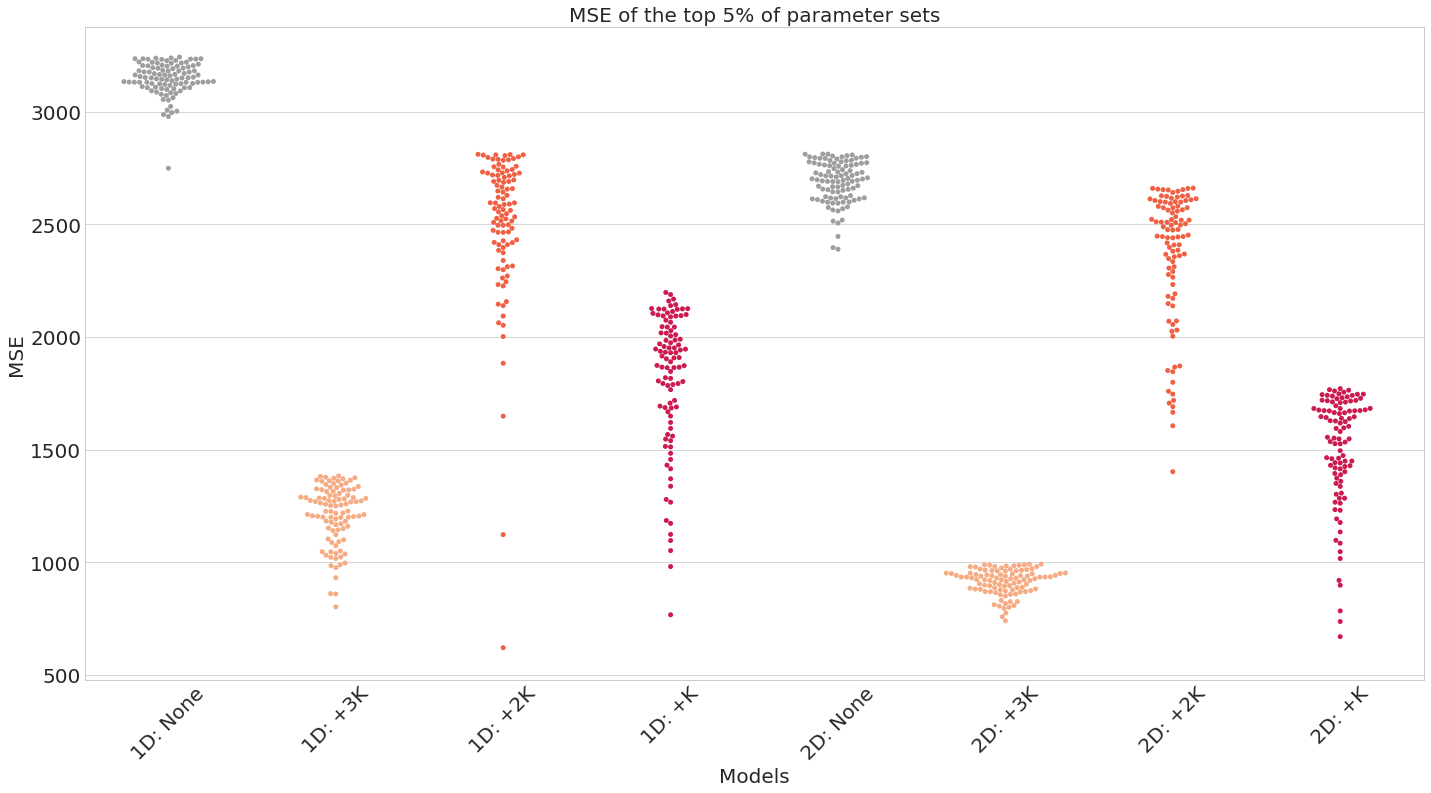

In [132]:
# plt.rcParams['figure.figsize'] = [24.0, 12.0]
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()
# rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [ 
        last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D, 
        last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses([
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K',
           '2D: None', '2D: +3K', '2D: +2K', '2D: +K'], mses, 0.05, colors,'181024/mses_delay')

# Extra

## Plot MAP2K

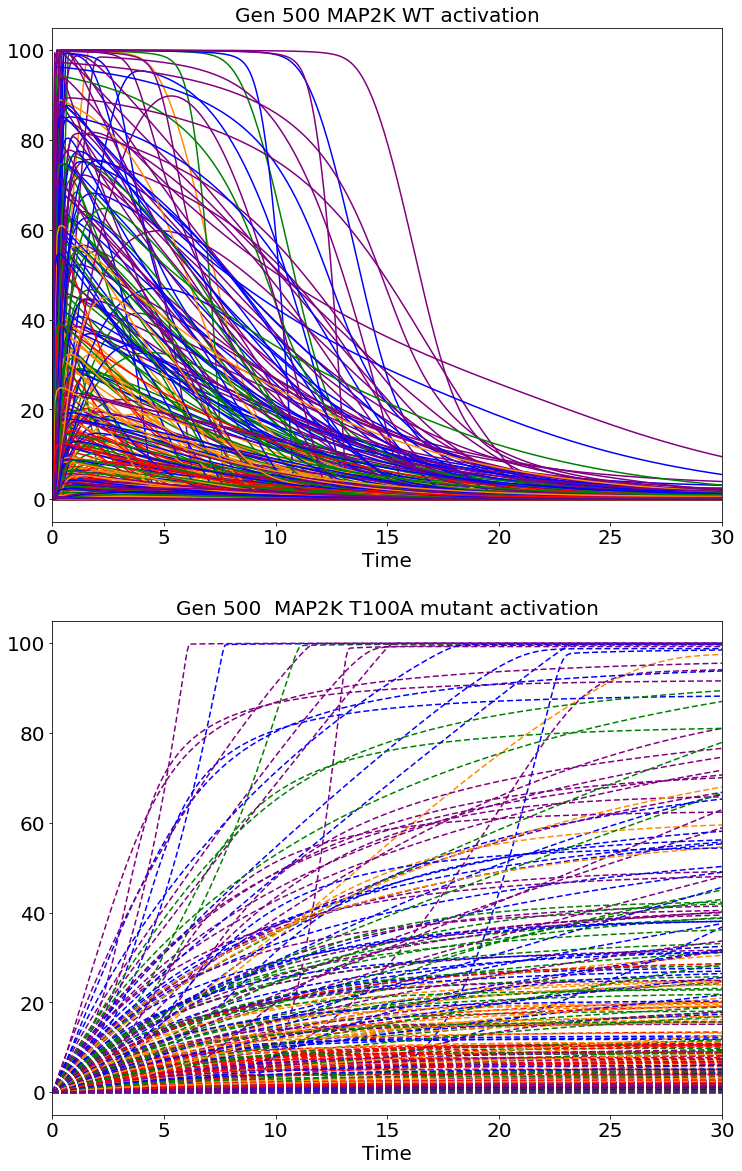

In [324]:
dt = 0.1
steps = 300
time = np.linspace(0,dt*steps,steps)

#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,20))

#plot 1
title_text = 'Gen ' + str(gen) + ' MAP2K WT activation'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,1]/params_constants[1]*100
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,30)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  MAP2K T100A mutant activation'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,1]/params_constants[1]*100
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,30)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot MAP3K

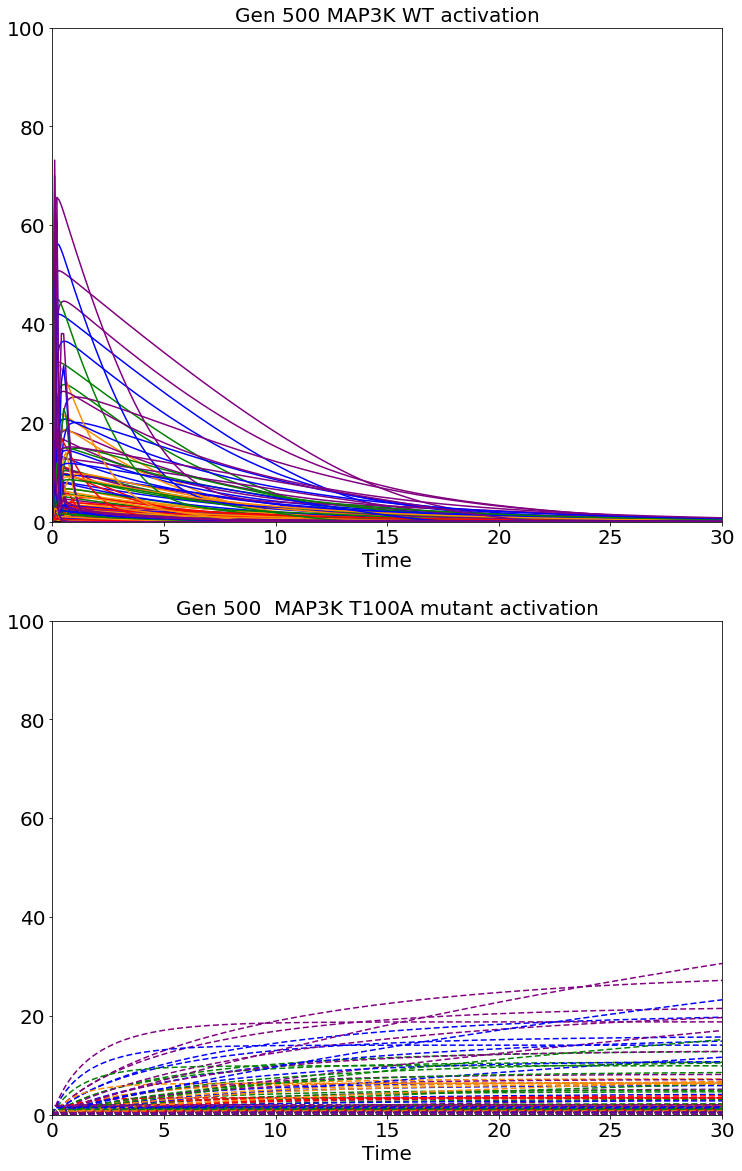

In [325]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,20))

#plot 1
title_text = 'Gen ' + str(gen) + ' MAP3K WT activation'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
# color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,0]/params_constants[0]*100
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,30)
        ax1.set_ylim(0,100)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  MAP3K T100A mutant activation'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,0]/params_constants[0]*100
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,30)
        ax2.set_ylim(0,100)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot Active Cytosolic MAPK

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' active cytosolic MAPK'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
ax1.set_ylim([0,100])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,2]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  active cytosolic MAPK'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,2]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot Active Nuclear MAPK

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' nuclear MAPK'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,3]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  nuclear MAPK'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,3]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot X

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' active X'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,4]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  active X'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,4]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Visualize individual param sets

In [ ]:
color_palette = sns.color_palette("rocket", 6)[::-1]

for i, params in enumerate(top_params):
#     beta_1, beta_2, alpha, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, kn, kc = params
#     params = beta_1, beta_2, 0, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, 0, kc
    #plot real data:
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        plt.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
        plt.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
        data = odeint(b0_D, initals, time, args=(params_constants[:-1]+[signal], params))
        active = data[:,2]+data[:,3]
        plt.plot(time, active, label=str(signal)+' WT active', color=color_palette[idx])
#         plt.plot(time, data[:,4], dashes=[2, 2], label=str(signal)+' X')
        data = simulate_t100a_experiment(initals, params_constants[:-1]+[signal], params, time)
        active = data[:,2]+data[:,3]
        plt.plot(time, active, label=str(signal)+' T100A active', dashes= [4,2], color=color_palette[idx])
#         plt.plot(time, data[:,3], label=str(signal)+' MAPKn')
    plt.title(f'Param set {i}')
    plt.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.ylim(0,100)
    plt.show()

## Compare parameter correlations

In [ ]:
top_params_T = np.asarray(top_params).T

# idx = 18
for idx in range(len(top_params_T)):
    for i in range(len(top_params_T)):
        corr = np.corrcoef(top_params_T[idx],top_params_T[i])[0][1]
        if abs(corr) > 0.6 and abs(corr) < 0.999:
            print(labelnames[idx] + ' vs. '+ labelnames[i])
            print(np.corrcoef(top_params_T[idx],top_params_T[i])[0][1])
#     fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16,6))
#     ax1.scatter(top_params_T[idx],top_params_T[i])
#     ax1.set_ylabel(labelnames[i])
#     ax1.set_title('Raw')
#     ax2.semilogy(top_params_T[idx],top_params_T[i],'o')
#     ax2.set_xscale('log')
#     ax2.set_title('Log')
#     plt.show()


In [ ]:
idx = 0
for i in range(len(top_params_T)):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16,6))
    ax1.scatter(top_params_T[idx],top_params_T[i])
    ax1.set_ylabel(labelnames[i])
    ax1.set_title('Raw')
    ax2.semilogy(top_params_T[idx],top_params_T[i],'o')
    ax2.set_xscale('log')
    ax2.set_title('Log')
    plt.show()


# Model investigation

In [ ]:
top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]

In [ ]:
print(top_params[0])
beta_0,    k0, k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8,   X_t = top_params[0]
top_params[0] = beta_0,    k0, k1, .1, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8,   X_t
for idx, sig in enumerate(params_constants[-1]):
    params_c = params_constants[:-1]+[sig]
    data = simulate_wt_experiment(initals, params_c, top_params[0], time)
    active = (data[:,2] + data[:,3])/params_constants[2]*100
    plt.plot(time, active, color=color_palette[idx])
    plt.ylim(0,100)

# Results Notes 